Load some libraries we will use:

In [314]:
#from itertools import product
import numpy as np
from scipy import optimize
from scipy import interpolate
import sympy as sm

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
plt.style.use('seaborn-whitegrid')
import seaborn as sns

<br>

# AS-AD model
(Exercise inspired by Jeppe Druedahl's exercises for https://numeconcopenhagen.netlify.app/)

Consider the following AS-AD model with a Taylor rule. The AD curve, obtained by combining the Taylor rule and goods market clearing, is given by  
$$
\pi_{t} = \pi^{*}-\frac{1}{\alpha}\left[y_{t}-\bar{y}-z_{t}\right]
$$
where $ \alpha = \frac{\alpha_2h}{1+\alpha_2b}$ and $z_t = \frac{v_t}{1+\alpha_2b}$. 

[Note compared to lecture we are implicitly setting $\hat{\rho}_t=g_t=\bar{g}=0$.]

The short-run supply curve (SRAS) is given by
$$
\pi_{t} = \pi_{t}^{e} + \gamma (y_{t}-\bar{y}) + s_{t}
$$
where $s_t$ is a supply shock. 

Inflation expectations are adaptive and given by
$$
\pi_{t}^{e} = \phi\pi_{t-1}^{e} + (1-\phi)\pi_{t-1}
$$
Together, this implies that the SRAS-curve can also be written as
$$
\pi_{t} = \pi_{t-1} + \gamma y_{t} - \phi\gamma y_{t-1} + s_{t} - \phi s_{t-1}
$$

<br>

## 1. Define parameters (10%)
Assume we want to calibrate a quarterly model. Choose values for the parameters below and save them in a dictionary called par. Justify the value you set for each parameter.

In [315]:
par = {}

par['alpha2'] = 0.8 # [0,1] responsiveness of the policy intrest rate to the output gap
par['h'] = 1.0 # [0,2] elasticity of aggregate demand to changes in the real interest rate
par['b'] = 0.1 # [0,1] dampening factor for the output gap
# for h and b) 
# if h is a high value then AD curve is more flat 
# same if b is a lower value
par['phi'] = 0.20 # [0,1] the expected inflation weight  
par['gamma'] = 0.1 # [0,1] the weight on the output gap in the Phillips curve. normaly small value
par['pistar'] = 0 # zero inflation in steady state
par['ybar'] = 0 # zero output gap in steady state

<br>

## 2. Solve for the equilibrium

Next, we use the ``sympy`` module to solve for the equilibrium values of output, $y_t$, and inflation, $\pi_t$ given the parameters ($\alpha_2$, $h$, $b$, $\phi$, $\gamma$) and initial values $y_{t-1}$ , $\pi_{t-1}$, $v_t$, $s_t$, and $s_{t-1}$. The equilibrium is defined by the point where AD = SRAS. 

We will do this together since the rest of the assignment relies on these functions. First we construct the AD curve (Step 1), then the AS curve (Step 2), and finally we compute the equilibrium functions (Step 3).

``SymPy`` should automatically render these as typeset "pretty" equations.

<br>

### 2.1 Construct the AD curve: 
We construct the AD curve, $\pi_{t} = \pi^{*}-\frac{1}{\alpha}\left[y_{t}-\bar{y}-z_{t}\right]
$, where $ \alpha = \frac{\alpha_2h}{1+\alpha_2b}$ and $z_t = \frac{v_t}{1+\alpha_2b}$.

In [316]:
y = sm.symbols('y_t')
ybar = sm.symbols('\\bar{y}')
v = sm.symbols('v_t')
alpha2 = sm.symbols('alpha_2')
pistar = sm.symbols('\pi^{*}')
h = sm.symbols('h')
b = sm.symbols('b')
alpha = sm.symbols('alpha')
z = sm.symbols('z_t')

z = v/(1+alpha2*b)
alpha = alpha2*h/(1+alpha2*b)
AD = pistar-1/alpha * (y-ybar-z)
AD

\pi^{*} - (alpha_2*b + 1)*(-\bar{y} - v_t/(alpha_2*b + 1) + y_t)/(alpha_2*h)

<br>

### 2.2 Construct the AS curve: 
Similarly for the SRAS curve, $\pi_{t} = \pi_{t-1} + \gamma y_{t} - \phi\gamma y_{t-1} + s_{t} - \phi s_{t-1}$

In [317]:
phi = sm.symbols('phi')
gamma = sm.symbols('gamma')
pilag = sm.symbols('\pi_{t-1}')
ylag = sm.symbols('y_{t-1}')
s = sm.symbols('s_t')
slag = sm.symbols('s_{t-1}')

SRAS = pilag + gamma*y- phi*gamma*ylag + s - phi*slag
SRAS

\pi_{t-1} - gamma*phi*y_{t-1} + gamma*y_t - phi*s_{t-1} + s_t

<br>

### 2.3 Find the solution: 
Next we find the solution for output by equating AS and AD using ``sympy``'s ``solve`` and ``Eq`` methods. 

To find the solution for inflation, evaluate either the AD or AS curve at the equilibrium output value we just found using the ``subs`` method.

In [318]:
y_eq = sm.solve(sm.Eq(AD,SRAS),y)
y_eq[0]

(\bar{y}*alpha_2*b + \bar{y} + \pi^{*}*alpha_2*h - \pi_{t-1}*alpha_2*h + alpha_2*gamma*h*phi*y_{t-1} + alpha_2*h*phi*s_{t-1} - alpha_2*h*s_t + v_t)/(alpha_2*b + alpha_2*gamma*h + 1)

In [319]:
pi_eq = AD.subs(y,y_eq[0])
pi_eq

\pi^{*} - (alpha_2*b + 1)*(-\bar{y} - v_t/(alpha_2*b + 1) + (\bar{y}*alpha_2*b + \bar{y} + \pi^{*}*alpha_2*h - \pi_{t-1}*alpha_2*h + alpha_2*gamma*h*phi*y_{t-1} + alpha_2*h*phi*s_{t-1} - alpha_2*h*s_t + v_t)/(alpha_2*b + alpha_2*gamma*h + 1))/(alpha_2*h)

<br>

## 3. Illustrate the equilibrium (20%)
The code below finds and illustrates (= plots in $(y,\pi)$-space) the equilibrium without shocks, that is, when $y_{t-1} = \pi_{t-1} = v_t = s_t = s_{t-1} = 0$. 

After going through the code, you are asked to find and illustrate the equilibrium with $v_t = 0.1$.

Convert the ``SymPy`` functions to ``NumPy`` functions that can be evaluated quickly numerically using lambdify:

In [320]:
AD_func = sm.lambdify((y,v,alpha2,h,b,pistar,ybar),AD)
SRAS_func = sm.lambdify((y,s,ylag,pilag,slag,phi,gamma),SRAS)
y_eq_func = sm.lambdify((ylag,pilag,v,s,slag,alpha2,h,b,pistar,ybar,phi,gamma),y_eq[0])
pi_eq_func = sm.lambdify((ylag,pilag,v,s,slag,alpha2,h,b,pistar,ybar,phi,gamma),pi_eq)

Construct grids to draw the curves

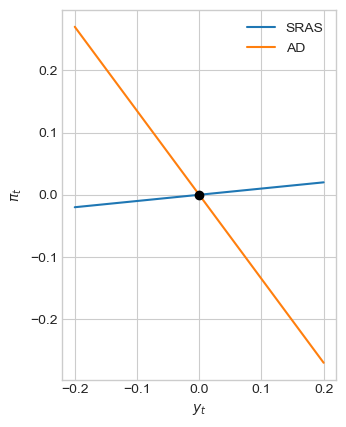

In [321]:
# a. lagged values and shocks 
y0_lag = 0.0
pi0_lag = 0.0
s0 = 0.0
s0_lag = 0.0

# b. current output
y_vec = np.linspace(-0.2,0.2,100)

# c. figure
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_aspect('equal', adjustable='box')

# SRAS
pi_SRAS = SRAS_func(y_vec,s0,y0_lag,pi0_lag,s0_lag,par['phi'],par['gamma'])
ax.plot(y_vec,pi_SRAS,label='SRAS')

# AD
v0 = 0
pi_AD = AD_func(y_vec,v0,par['alpha2'],par['h'],par['b'],par['pistar'],par['ybar'])
ax.plot(y_vec,pi_AD,label='AD')

# equilibrium
eq_y = y_eq_func(y0_lag,pi0_lag,v0,s0,s0_lag,par['alpha2'],par['h'],par['b'],par['pistar'],par['ybar'],par['phi'],par['gamma'])
eq_pi =pi_eq_func(y0_lag,pi0_lag,v0,s0,s0_lag,par['alpha2'],par['h'],par['b'],par['pistar'],par['ybar'],par['phi'],par['gamma'])
ax.scatter(eq_y,eq_pi,color='black',zorder=3)

ax.set_xlabel('$y_t$')
ax.set_ylabel('$\pi_t$')
ax.legend();

<br>

### Your job: 
Find and add to the plot the AD and AS curves, along with the equilibrium points, when $v_t = 0.1$. Explain in economic terms what changes and why when $v_t = 0$ versus when $v_t = 0.1$.

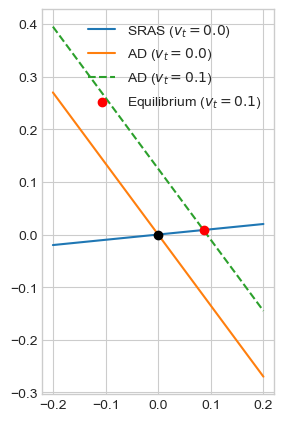

In [322]:
v1 = 0.1

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(1,1,1)
ax.set_aspect('equal')

# SRAS
pi_SRAS = SRAS_func(y_vec,s0,y0_lag,pi0_lag,s0_lag,par['phi'],par['gamma'])
ax.plot(y_vec,pi_SRAS,label='SRAS ($v_t=0.0$)')

# AD
v0 = 0
pi_AD = AD_func(y_vec,v0,par['alpha2'],par['h'],par['b'],par['pistar'],par['ybar'])
ax.plot(y_vec,pi_AD,label='AD ($v_t=0.0$)')

# equilibrium
eq_y = y_eq_func(y0_lag,pi0_lag,v0,s0,s0_lag,par['alpha2'],par['h'],par['b'],par['pistar'],par['ybar'],par['phi'],par['gamma'])
eq_pi =pi_eq_func(y0_lag,pi0_lag,v0,s0,s0_lag,par['alpha2'],par['h'],par['b'],par['pistar'],par['ybar'],par['phi'],par['gamma'])
ax.scatter(eq_y,eq_pi,color='black',zorder=3)

# AD with v1 shock
pi_AD_v1 = AD_func(y_vec, v1, par['alpha2'], par['h'], par['b'], par['pistar'], par['ybar'])
ax.plot(y_vec, pi_AD_v1, label='AD ($v_t=0.1$)', linestyle='--')

# equilibrium with v1 shock
eq_y_v1 = y_eq_func(y0_lag, pi0_lag, v1, s0, s0_lag, par['alpha2'], par['h'], par['b'], par['pistar'], par['ybar'], par['phi'], par['gamma'])
eq_pi_v1 = pi_eq_func(y0_lag, pi0_lag, v1, s0, s0_lag, par['alpha2'], par['h'], par['b'], par['pistar'], par['ybar'], par['phi'], par['gamma'])
ax.scatter(eq_y_v1, eq_pi_v1, color='red', zorder=3, label='Equilibrium ($v_t=0.1$)')

ax.legend()
plt.show()

A positive shock in aggregate demand will mean a slight increase in inflation and a bigger increase in real output.

If gamma was larger, then the inflation would be even higher because the SRAS would be steeper. But for lower gamma, companies increase productivity without large changes in inflation.

<br>

## 4. Impulse responses (30%)
Now we will assume that both the demand and the supply disturbances are AR(1) processes

$$ 
\begin{aligned}
v_{t} &= \delta v_{t-1} + x_{t} \\
s_{t} &= \omega s_{t-1} + c_{t} 
\end{aligned}
$$

where $x_{t}$ is a demand shock, and $c_t$ is a supply shock 

The autoregressive parameters are given by

In [323]:
par['delta'] = 0.80
par['omega'] = 0.15

Assume that $x_t$ and $c_t$ are  normally distributed

$$ 
\begin{aligned}
x_{t}&\sim\mathcal{N}(0,\sigma_{x}^{2}) \\
c_{t}&\sim\mathcal{N}(0,\sigma_{c}^{2}) \\
\end{aligned}
$$

with standard deviations

In [324]:
par['sigma_x'] = 1.0
par['sigma_c'] = 0.2

<br>

We will now construct impulse responses to answer the following question: *Starting from the long-run equilibrium, how does the economy evolve in response to a one-time, one standard-deviation demand shock?* 

The starting point of the economy is $y_{-1} = \pi_{-1} = s_{-1} = 0$. 
The shock sequence we are considering is: $x_0 = \sigma_x$, $x_t = 0, \forall t > 0$ and $c_t = 0, \forall t \geq 0$.

*Step 1*
Define two functions that we will reuse later:
1. allocate memories and draw random shocks given parameters and the number of time periods we want to simulate
2. simulate the economy given the shock sequences from 1. 

*Step 2*
Run the simulations.

*Step 3*
Illustrate the results in two ways: 
1. in $(y,\pi)$-space, and 
2. plotting $y$ and $\pi$ as a function of periods since the shock. 

<br>

**Step 1**:
Define function prep_sim to **allocate memory and draw random shocks**

In [325]:
def prep_sim(par,T,seed=1986):
    """ prepare simulation
    
    Args:
    
        par (dict): model parameters
        T (int): number of periods to simulate
        seed (int,optional): seed for random numbers
        
    Returns:
    
        sim (dict): container for simulation results
        
    """
    
    # a. set seed
    if not seed == None:
        np.random.seed(seed)
    
    # b. allocate memory
    sim = {}
    sim['y'] = np.zeros(T)
    sim['pi'] = np.zeros(T)
    sim['v'] = np.zeros(T)
    sim['s'] = np.zeros(T)
    
    # c. draw random shocks
    sim['x_raw'] = np.random.normal(loc=0,scale=1,size=T)
    sim['c_raw'] = np.random.normal(loc=0,scale=1,size=T)
    
    return sim

**Step 1 (continued)**:
Define function **simulate** to run the simulations

In [326]:
def simulate(par,sim,T):
    """ run simulation
    
    Args:
    
        par (dict): model parameters
        sim (dict): container for simulation results        
        T (int): number of periods to simulate
                
    """
    
    for t in range(1,T):
        
        # a. shocks
        sim['v'][t] = par['delta']*sim ['v'][t-1] + par['sigma_x']*sim['x_raw'][t]
        sim['s'][t] = par['omega']*sim ['s'][t-1] + par['sigma_c']*sim['c_raw'][t]
        
        # b. output
        sim['y'][t] = y_eq_func(sim['y'][t-1],sim['pi'][t-1],sim['v'][t],sim['s'][t],sim['s'][t-1],
                                par['alpha2'],par['h'],par['b'],par['pistar'],par['ybar'],par['phi'],par['gamma'])
        
        # c. inflation
        sim['pi'][t] = pi_eq_func(sim['y'][t-1],sim['pi'][t-1],sim['v'][t],sim['s'][t],sim['s'][t-1],
                                  par['alpha2'],par['h'],par['b'],par['pistar'],par['ybar'],par['phi'],par['gamma'])
        

<br>

**Step 2:** Run the simulations

In [327]:
# a. settings: number of periods to simulate
T = 100

# b. prepare simulation
sim = prep_sim(par,T)

# c. define (overwrite) shock sequences. We want a one time, one standard deviation increase in x_t in period 1 only
sim['x_raw'][:] = 0
sim['c_raw'][:] = 0
sim ['x_raw'][1] = 1 #par['sigma_x']

# d. run simulation
simulate(par,sim,T)

<br>

**Step 3:** Plot the simulated time series in a **$(y_t,\pi_t)$-diagram**

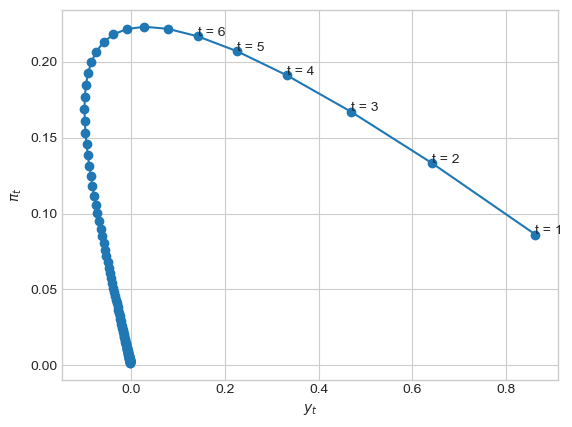

In [328]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(sim['y'][1:],sim['pi'][1:],ls='-',marker='o')
ax.set_xlabel('$y_t$')
ax.set_ylabel('$\pi_t$');
for i in range(1,7):
    ax.text(sim['y'][i],sim['pi'][i]+0.0002,f't = {i}')

**Step 3 (continued):** Plot the simulated series for output and inflation **over time**

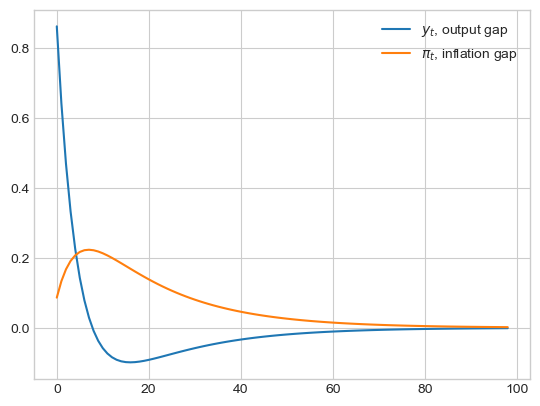

In [329]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(np.arange(0,T-1),sim['y'][1:],label='$y_t$, output gap')
ax.plot(np.arange(0,T-1),sim['pi'][1:],label='$\pi_t$, inflation gap')
ax.legend();

<br>

### Your job: 
1. Add code to also simulate the nominal and real interest rates and add a figure that plot the simulated time series over time. Assume the central bank follows a Taylor rule of the form $i_t =\pi_t +h(\pi_t-\pi^*)+b(y_t-\bar{y})$.

2. Explain the response of the economy to the demand shock in economic terms.

3. Add code below to simulate the economy's response to a one time, one standard deviation *supply* shock, that is $c_0 = \sigma_c$, $c_t = 0, \forall t > 0$ and $x_t = 0, \forall t \geq 0$.

4. Produce 3 figures: Plot the simulated data for output gap and inflation in $(y,\pi)$-space and over time, and plot the response of the nominal and real interest rates over time. 

5. Explain the response of the economy to the supply shock in economic terms.

In [330]:
def prep_sim(par,T,seed=1986):
    """ prepare simulation
    
    Args:
    
        par (dict): model parameters
        T (int): number of periods to simulate
        seed (int,optional): seed for random numbers
        
    Returns:
    
        sim (dict): container for simulation results
        
    """
    
    # a. set seed
    if not seed == None:
        np.random.seed(seed)
    
    # b. allocate memory
    sim = {}
    sim['y'] = np.zeros(T)
    sim['pi'] = np.zeros(T)
    sim['v'] = np.zeros(T)
    sim['s'] = np.zeros(T)

    sim['nominal interest rate'] = np.zeros(T)
    sim['real interest rate'] = np.zeros(T)
    
    # c. draw random shocks
    sim['x_raw'] = np.random.normal(loc=0,scale=1,size=T)
    sim['c_raw'] = np.random.normal(loc=0,scale=1,size=T)
    
    return sim

In [331]:
def simulate_new(par,sim,T):
    """ run simulation
    
    Args:
    
        par (dict): model parameters
        sim (dict): container for simulation results        
        T (int): number of periods to simulate
                
    """

    for t in range(1,T):

        # a. shocks
        sim['v'][t] = par['delta']*sim ['v'][t-1] + par['sigma_x']*sim['x_raw'][t]
        sim['s'][t] = par['omega']*sim ['s'][t-1] + par['sigma_c']*sim['c_raw'][t]
        
        # b. output
        sim['y'][t] = y_eq_func(sim['y'][t-1],sim['pi'][t-1],sim['v'][t],sim['s'][t],sim['s'][t-1],
                                par['alpha2'],par['h'],par['b'],par['pistar'],par['ybar'],par['phi'],par['gamma'])
        
        # c. inflation
        sim['pi'][t] = pi_eq_func(sim['y'][t-1],sim['pi'][t-1],sim['v'][t],sim['s'][t],sim['s'][t-1],
                                  par['alpha2'],par['h'],par['b'],par['pistar'],par['ybar'],par['phi'],par['gamma'])
        
        # d. nominal interest rate,  real interest rate
        sim['nominal interest rate'][t] = sim['pi'][t] + par['h']* (sim['pi'][t] - par['pistar']) + par['b'] * (sim['y'][t] - par['ybar'])

        sim['real interest rate'][t] = sim['nominal interest rate'][t] - (par["phi"]*sim["pi"][t-1] + (1-par["phi"])*sim["pi"][t-1])
        


step 2


In [332]:
# a. settings: number of periods to simulate
T = 100

# b. prepare simulation
sim = prep_sim(par,T)

# c. define (overwrite) shock sequences. We want a one time, one standard deviation increase in x_t in period 1 only
sim['x_raw'][:] = 0
sim['c_raw'][:] = 0
sim ['x_raw'][1] = 1 #par['sigma_x']

# d. run simulation
simulate_new(par,sim,T)

step 3 over time

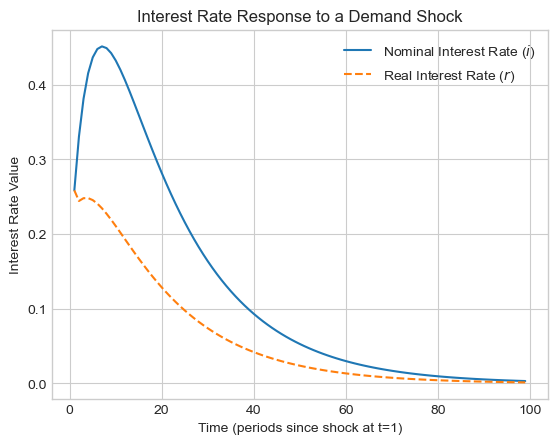

In [333]:
# fig = plt.figure()
# ax = fig.add_subplot(1,1,1)

# ax.plot(sim['nominal interest rate'][1:],sim['real interest rate'][1:],ls='-',marker='o')
# ax.set_xlabel('$y_t$')
# ax.set_ylabel('$\pi_t$');

fig = plt.figure()
ax = fig.add_subplot(1,1,1)

# Plot nominal interest rate over time (from t=1 onwards)
ax.plot(np.arange(1, T), sim['nominal interest rate'][1:], label='Nominal Interest Rate ($i$)', ls='-')
# Plot real interest rate over time (from t=1 onwards)
ax.plot(np.arange(1, T), sim['real interest rate'][1:], label='Real Interest Rate ($r$)', ls='--')

ax.set_xlabel('Time (periods since shock at t=1)')
ax.set_ylabel('Interest Rate Value')
ax.set_title('Interest Rate Response to a Demand Shock')
ax.legend()
plt.show()


step 3 


In [334]:
# a. settings: number of periods to simulate
T = 100

# b. prepare simulation
sim = prep_sim(par,T)

# c. define (overwrite) shock sequences. We want a one time, one standard deviation increase in x_t in period 1 only
sim['x_raw'][1] = 1

sim ['x_raw'][1] = 0 

# d. run simulation
simulate_new(par,sim,T)

<br>

**Step 3:** Plot the simulated time series in a **$(y_t,\pi_t)$-diagram**

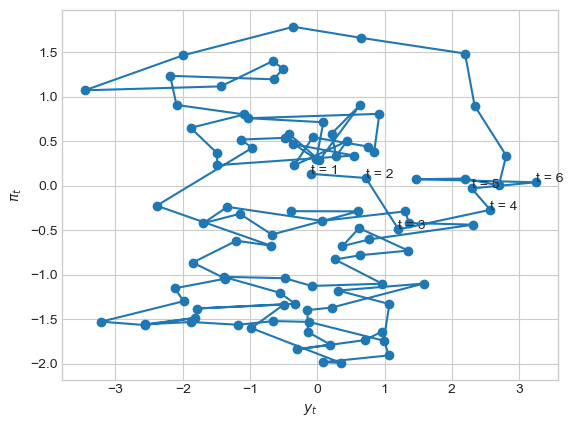

In [335]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(sim['y'][1:],sim['pi'][1:],ls='-',marker='o')
ax.set_xlabel('$y_t$')
ax.set_ylabel('$\pi_t$');
for i in range(1,7):
    ax.text(sim['y'][i],sim['pi'][i]+0.0002,f't = {i}')

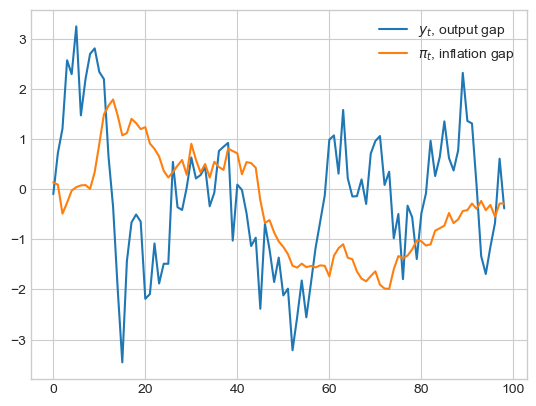

In [338]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(np.arange(0,T-1),sim['y'][1:],label='$y_t$, output gap')
ax.plot(np.arange(0,T-1),sim['pi'][1:],label='$\pi_t$, inflation gap')
ax.legend();

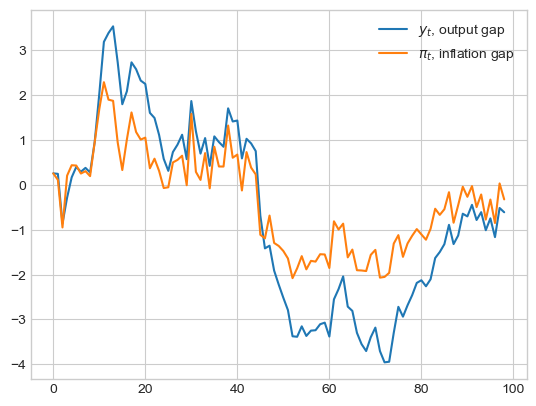

In [341]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(np.arange(0,T-1),sim['nominal interest rate'][1:],label='$y_t$, output gap')
ax.plot(np.arange(0,T-1),sim['real interest rate'][1:],label='$\pi_t$, inflation gap')
ax.legend();

## 5. Simulating the model and calculating business cycle statistics (20%)

Continue to make the same assumptions about the shock processes as in the last question. Now instead of computing impulse responses (a one-time shock) simulate the AS-AD model for 100 periods (drawing a realization of $x_t$ and $c_t$ each of these periods). Plot the resulting time series and calculate the following five statistics using ``std`` and ``corrcoef`` from ``numpy``:

1. Variance of $y_t$, $var(y_t)$
2. Variance of $\pi_t$, $var(\pi_t)$ 
3. Correlation between $y_t$ and $\pi_t$, $corr(y_t,\pi_t)$
4. Auto-correlation between $y_t$ and $y_{t-1}$, $corr(y_t,y_{t-1})$
5. Auto-correlation between $\pi_t$ and $\pi_{t-1}$, $corr(\pi_t,\pi_{t-1})$

Are output and inflation positively or negatively related? Why? What might change the sign and magnitude of the correlation?

In [ ]:
# your code here    
# a. settings: number of periods to simulate
T = 100

# b. prepare simulation
sim = prep_sim(par,T)

# c. run simulation
simulate_new(par,sim,T)



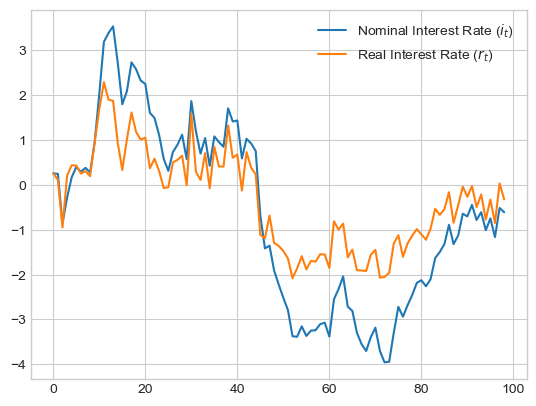

In [343]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(np.arange(0,T-1),sim['nominal interest rate'][1:],label='Nominal Interest Rate ($i_t$)')
ax.plot(np.arange(0,T-1),sim['real interest rate'][1:],label='Real Interest Rate ($r_t$)')
ax.legend()

In [347]:
y_sim = sim['y'][1:]
pi_sim = sim['pi'][1:]

var_y = np.var(y_sim)
var_pi = np.var(pi_sim)
corr_y_pi = np.corrcoef(y_sim, pi_sim)[0, 1]
corr_y_ylag = np.corrcoef(sim['y'][1:], sim['y'][:-1])[0, 1]
corr_pi_pilag = np.corrcoef(sim['pi'][1:], sim['pi'][:-1])[0, 1]



print(f"Variance of y_t: {var_y}")
print(f"Variance of pi_t: {var_pi}")
print(f"Correlation between y_t and pi_t: {corr_y_pi}")
print(f"Correlation between y_t and y_{T-1}: {corr_y_ylag}")
print(f"Correlation between pi_t and pi_{T-1}: {corr_pi_pilag}")



Variance of y_t: 1.8984334687354172
Variance of pi_t: 0.9925779654311516
Correlation between y_t and pi_t: 0.05562454953019339
Correlation between y_t and y_99: 0.7943554613502758
Correlation between pi_t and pi_99: 0.9733246592321673


<br>

## 6. Calibration (20%)

Now based on simulations of T=100 periods each, plot how the correlation between $y_t$ and $\pi_t$ changes with $\phi$. Explain. What value of $\phi$ brings the correlation between inflation and output close to its empirical counterpart of 0.31? 

How large does $T$ need to be for this value to not change very much with each simulation?

If you would like to, you can use a numerical optimizer or root finder to choose $\phi\in(0,1]$ such that the simulated correlation between $y_t$ and $\pi_t$ comes close to 0.31. 

In [337]:
# your code here